In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import matplotlib as mpl, warnings
import numpy as np

In [5]:
exps  = ['exp1','exp2','exp3','exp4']
funcs = ['sphere','rastrigin','rosenbrock']
freq = 20
nn_p = 3
nn_w = 5
dimension=30
norm_check = np.sqrt(dimension*(10**2)) #10=5-(-5) this line is to normalize error values, we divide them to the biggest distance between two points in decision space 

In [6]:
# funcs
# pat = re.compile('.*/(exp\d)/(\w*)/nonn/freq([0-9\.]+)div(\w+)/(\w+)_\w+.csv')
# decode_keys = ['experiment','function','freq','div','method']
# nn_pat = re.compile('.*/(exp\d)/(\w*)/nn/freq([0-9\.]+)\w+nn_p(\d+)\w+div([A-Za-z]+)/(\w+)_(\w+)_\w+.csv')
# nn_decode_keys = ['experiment','function','freq','nnp','div','method','replace_mech']
nn_pat = re.compile('.*/(exp\d)/(\w*)/nn/freq([0-9\.]+)nn_w(\d+)nn_p(\d+)\w+div([A-Za-z]+)/(\w+)_(\w+)_\w+.csv')
nn_decode_keys = ['experiment','function','freq','nnw','nnp','div','method','replace_mech']#,


def get_nn_files(m): return list(path.glob(f'**/nn/**/*{m}.csv'))

def df_mean(df, m):
#     for n,d in df.groupby(['experiment', 'function', 'freq', 'method']):
#         import pdb;pdb.set_trace()
#     cols = df.columns[:100]
#     means = df.loc[:,cols].mean(axis=1)
#     df[m] = means
#     df.rename({'0': m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df#.drop(cols, axis=1)


def read_nn_csv(f,m):
    df = pd.read_csv(f)
    df = df.mean().to_frame().T
    for k,v in zip(nn_decode_keys,nn_pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['replace_mech'] + '_' + df['div']
    df['method'] = df['method'].str.replace('NNnorm_Worst', 'NN')
    df.drop(['replace_mech','div'], axis=1, inplace=True)
    df = df_mean(df, m)
    return df

def get_data(m='nn_errors', normalize=False):
#     short_dict = {'NNnorm_Random':'NNR', 'NNnorm_Worst':'NNW', 'noNN_R':'noNN', 'noNN_RI': 'noNN_RI',
#                   'noNN_Cw':'noNN_Cw','noNN_No':'noNN_No', 'noNN_CwN':'noNN_CwN', 'noNN_CwcN':'noNN_CwcN','noNN_Cwc':'noNN_Cwc',  }
#     files = get_files(m)
    nn_files = get_nn_files(m)
    data = pd.concat([read_nn_csv(f,m) for f in nn_files])
    #data.method = data.method.apply(lambda x: short_dict[x])
    data = data[data.nnp.isna() | (data.nnp == str(nn_p))].drop('nnp', axis=1)
#     i added this to only consider nn_w = 5
    data = data[data['nnw']==str(nn_w)]
    if normalize:
        data_norm = (data.groupby(['experiment','function','freq','method'])[m.upper()].mean().reset_index()
                         .groupby(['experiment','function'])[m.upper()].min().reset_index()
                         .rename({m.upper():m.upper()+'_norm'}, axis=1))
        data = data.merge(data_norm, 'left')
        data[m.upper()+'_norm'] = data[m.upper()] / data[m.upper()+'_norm']
    return data.reset_index(drop=True)

def plot_one(exp, func, freq, ax, lbl_dict=None):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        lbl = row.method if lbl_dict is None else lbl_dict[row.method]
        ax.plot(range(9,100), row[:91].values, label=lbl, linewidth=2, alpha=0.65) #/norm_check

    return ax

path = Path(f'../../data/cluster_results')

df = get_data()

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# Plot errors

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

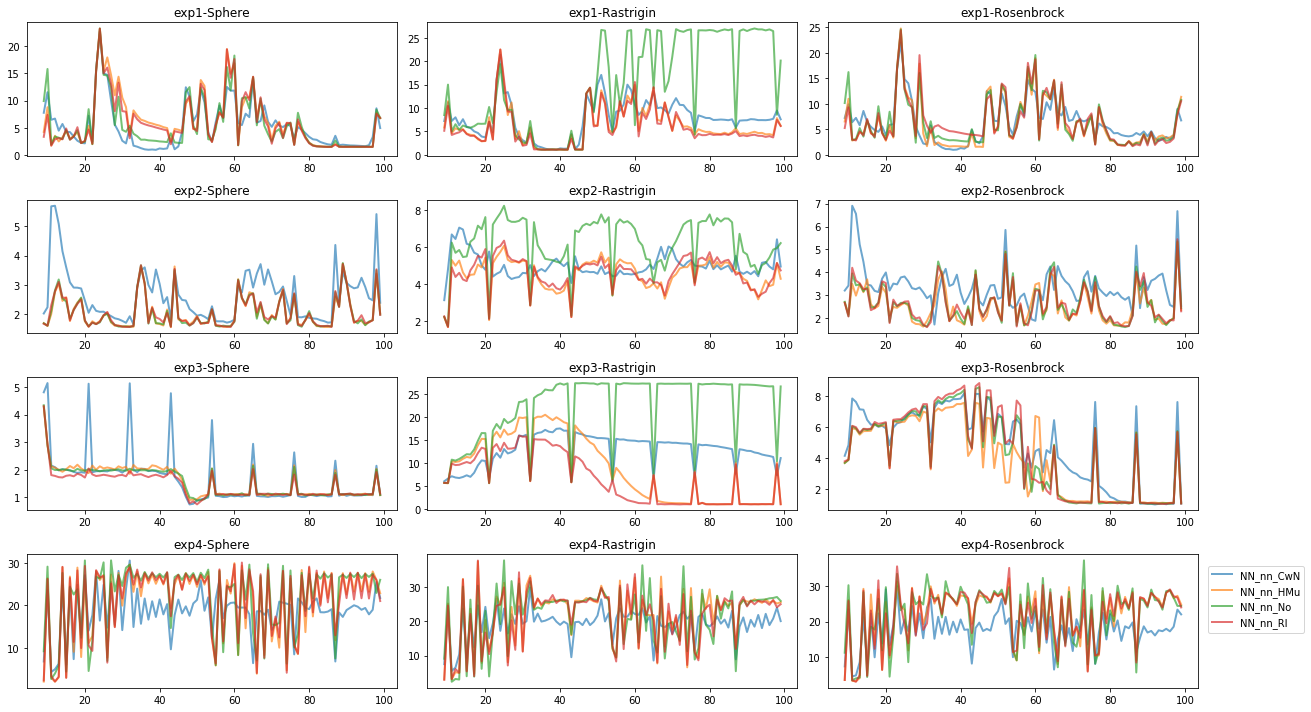

In [12]:
# only errors
fig,axs = plt.subplots(4, 3, figsize=(18,10))
# lbl_dict = {'NNnorm_Worst_fitness' :'NNW',
#             'NNnorm_Random_fitness':'NNR',
#             'noNNReval_fitness'    :'noNN',
#             'best_known'           :'best_known'}
lbl_dict = None

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax, lbl_dict)
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
#         if ax.get_ylim()[1] < 1e5:
# #             ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#             ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(loc='upper right', bbox_to_anchor=(0,0.15, 1.3, 0.8))#, bbox_to_anchor=(0,0, 0.5, 0.5))#best(0, -0.90, 0.5, 0.5)
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

fig.savefig(f'../../data/cluster_results/error{freq_lbl}.eps', dpi=400, format='eps')

In [13]:
#plot PCA and error together
from sklearn.decomposition import PCA

def plot_pca(func, axs=None):#i added this new pca plot for ppsn paper, to present pcaplot with another format
    exps = sorted([o.stem for o in Path().glob(f'*{func}*.npy')]) # retrieving file names
    source_data = []
    for exp in exps: source_data.append(pd.DataFrame(np.load(exp+'.npy')).assign(name=exp)) # reading files
    df_source = pd.concat(source_data) # putting all files together in a pandas dataframe
    d = df_source.iloc[:,:30] # grabs the values (30 dim)
    pca = PCA(1) # initialize PCA
    d_pca = pca.fit_transform(d) # reduces dimentions to 1
    dd = df_source.name.to_frame() # grabs from df_source only the names of experiments
    dd['value'] = d_pca[:,0] # adds the reduced dimentions to dd
    plot_data = dd.copy() # putting the data in format to plot
    plot_data['time'] = np.repeat(np.arange(100)[None], len(exps), 0).reshape(-1) # add time values 

    if axs is None: fig,axs = plt.subplots(1, 4, figsize=(16,0.8*len(exps))) # plot figures
    
    for exp,ax in zip(exps,axs):
        ax=ax.twinx() # remove thi sline if you dont want that pca plot appears in second axes
        texp,tfunc = exp.split('_')
        t = plot_data.query(f"name=={exp!r}")
        ax.plot(t['time'], t['value'] ,'-*', label=exp, c='crimson')
        ax.set_title(f'{texp}-{tfunc.title()}')
        ax.set_xlim(0,100)
    plt.tight_layout()
    return axs


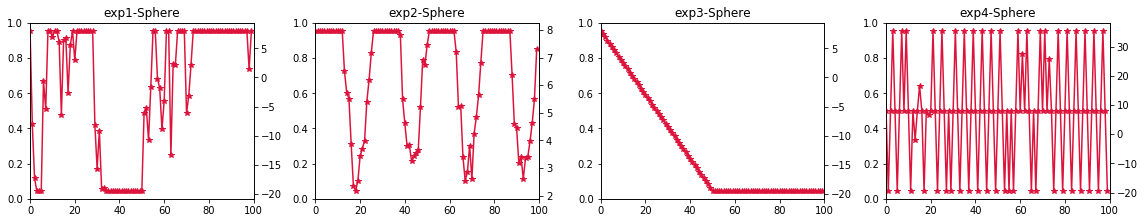

In [14]:
axs = plot_pca('sphere')
# fig.savefig(f'../../data/cluster_results/pcaPlot.eps', dpi=400, format='eps')
# plot_function('rosenbrock')
# plot_function('rastrigin')
#save(str(path/'pcaPlot.png'), scale_factor=2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

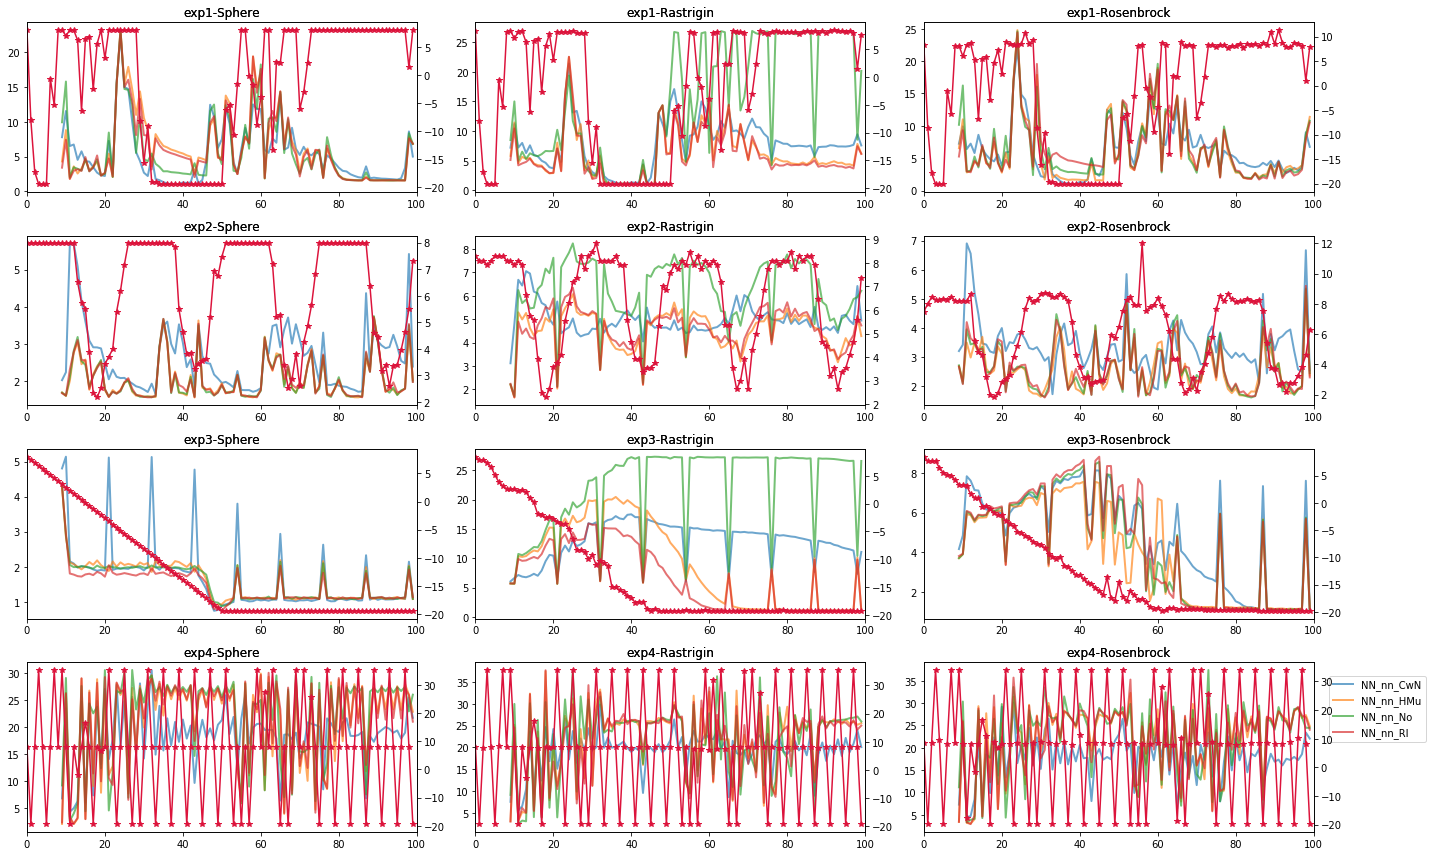

In [15]:
# errors and pca
fig,axs = plt.subplots(4, 3, figsize=(20,12))
# lbl_dict = {'NNnorm_Worst_fitness' :'NNW',
#             'NNnorm_Random_fitness':'NNR',
#             'noNNReval_fitness'    :'noNN',
#             'best_known'           :'best_known'}
lbl_dict = None

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax, lbl_dict)
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
ax.legend(loc='upper right', bbox_to_anchor=(0,0.15, 1.3, 0.8))#, bbox_to_anchor=(0,0, 0.5, 0.5))#best(0, -0.90, 0.5, 0.5)

# PCA
# axs2=axs.twinx()
for i,func in enumerate(['sphere', 'rastrigin', 'rosenbrock']): plot_pca(func, axs[:,i])

plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

fig.savefig(f'../../data/cluster_results/errorpca{freq_lbl}.eps', dpi=400, format='eps')

## one plot only!



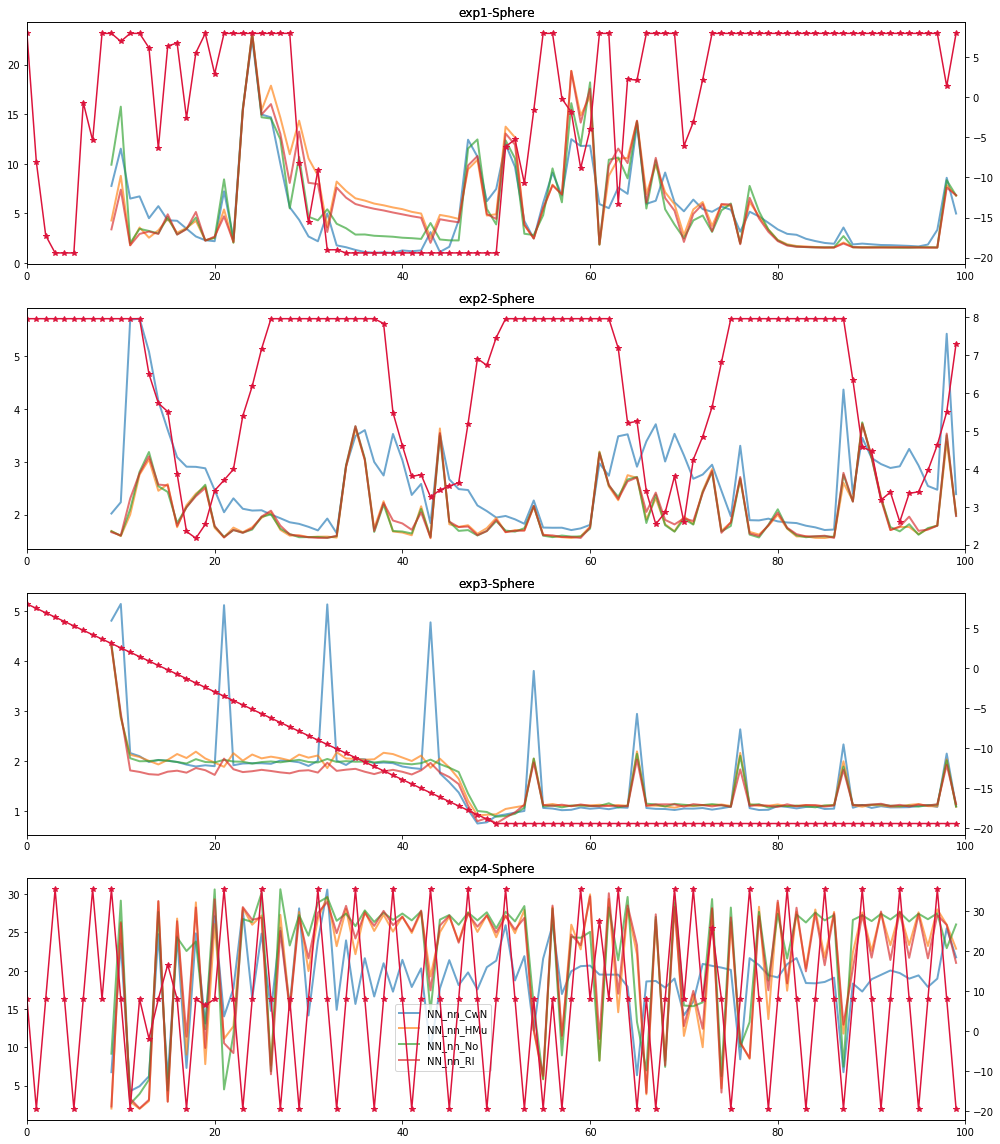

In [16]:
# errors and pca
fig,axs = plt.subplots(4, 1, figsize=(14,16))
# lbl_dict = {'NNnorm_Worst_fitness' :'NNW',
#             'NNnorm_Random_fitness':'NNR',
#             'noNNReval_fitness'    :'noNN',
#             'best_known'           :'best_known'}
lbl_dict = None
func='sphere'
for ax_row,exp in zip(axs,exps):
    plot_one(exp, func, freq, ax_row, lbl_dict)
    ax_row.set_title(f'{exp}-{func.title()}')
    ax_row.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
ax_row.legend(loc='upper right', bbox_to_anchor=(0,0, 0.5, 0.5))#, bbox_to_anchor=(0,0, 0.5, 0.5))#best(0, -0.90, 0.5, 0.5)

# PCA
plot_pca(func,axs)

plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

# fig.savefig(f'../../data/cluster_results/errorpca1{freq_lbl}.eps', dpi=400, format='eps')